# Customer Churn Analysis


# The story Behind The Data
Dollar Bank was concerned that more and more customers were leaving its credit card services. They asked me to use my Data Analytics skillsets to analyze the problem for them, in order to understand the main reasons for customers leaving the services. They also needed me to come up with recommendations for how the bank can mitigate further customer churns. Eventually, the bank wanted to proactively implement these recommendations in order to keep their customers happy.

**A full ERD of Dollar Bank's datasets can be found [here](https://dbdiagram.io/d/638cdd8abae3ed7c45449eed)**

# Data Description
In this task, few datasets are provided:

1. **`BankChurners.csv`**   - this file contains basic information about each client (10 columns). The columns are:
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account;
    - `Attrition Flag` - Internal event (customer activity) variable - if the client had churned (attrited) or not (existing).
    - `Dependent Count` - Demographic variable - Number of dependents
    - `Card_Category` - Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
    - `Months_on_book` - Period of relationship with bank
    - `Months_Inactive_12_mon` - No. of months inactive in the last 12 months
    - `Contacts_Count_12_mon` - No. of Contacts in the last 12 months
    - `Credit_Limit` - Credit Limit on the Credit Card
    - `Avg_Open_To_Buy` - Open to Buy Credit Line (Average of last 12 months)
    - `Avg_Utilization_Ratio` - Average Card Utilization Ratio
2. **`basic_client_info.csv`** - this file contains some basic client info per each client (6 columns) -
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account
    - `Customer Age` - Demographic variable - Customer's Age in Years
    - `Gender` - Demographic variable - M=Male, F=Female
    - `Education_Level` - Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.`
    - `Marital_Status` - Demographic variable - Married, Single, Divorced, Unknown
    - `Income_Category` - Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)
3. **`enriched_churn_data.csv`** - this file contains some enriched data about each client (7 columns) -
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account
    - `Total_Relationship_Count` - Total no. of products held by the customer
    - `Total_Revolving_Bal` - Total Revolving Balance on the Credit Card
    - `Total_Amt_Chng_Q4_Q1` - Change in Transaction Amount (Q4 over Q1)
    - `Total_Trans_Amt` - Total Transaction Amount (Last 12 months)
    - `Total_Trans_Ct` - Total Transaction Count (Last 12 months)
    - `Total_Ct_Chng_Q4_Q1` - Change in Transaction Count (Q4 over Q1)

# SQL tasks

After a thorough discussion with relevant business units and project stakeholders, business questions were translated into simple & advanced SQL queries to provide answers to frequently asked questions by the different business units and relevant project stakeholders.

1. How many clients does the bank have and are above the age of 50?
2. What’s the distribution (in %) between male and female clients?
3. Let’s define a new variable called `age_group`:
    - 10 < x ≤ 30
    - 30 < x ≤ 40
    - 40 < x ≤ 50
    - 50 < x ≤ 60
    - 60 <x ≤ 120
    
    Per each `age_group`, `marital_status` and `income_category`, find out the following values:
    
    a. Churn_rate (in %)
    
    b. Average `Total_Relationship_Count`
    
    c. Minimum value of `Total_Amt_Chng_Q4_Q1`
    
    d. Count of customers
    
    Make sure to order the data by the number of customers in descending order***
    
4. Out of the male clients, who are “blue” card holders, how many (in %) fall under the income category 40K - 60K?

5. Without the usage of group by at all, find the 3rd and 4th highest client IDs (`CLIENTNUM`’s) of `Total_Amt_Chng_Q4_Q1`?

6. We’re interested in knowing which client (CLIENTNUM) has the 2nd highest `Total_Trans_Amt`, Per each `Marital_Status`. 

The bank wanted to create a dedicated campaign to target these specific clients moving forward. So my task in this section was to help the bank find those clients.

See Customer Churn ERD below

![Customer Churn ERD](Customer%20Churn%20ERD.png)

**Question 1:**

How many clients does the bank have and are above the age of 50?

In [2]:
-- How many clients does the bank have and are above the age of 50?

SELECT COUNT(*) AS clients_above_50
FROM basic_client_info
WHERE customer_age > 50
;

,clients_above_50
0,3078


**Question 2:**

What’s the distribution (in %) between male and female clients?

In [3]:
-- What’s the distribution (in %) between male and female clients?
WITH total_count AS (
    SELECT 
        COUNT(*) AS total 
    FROM basic_client_info
    )
SELECT 
  gender,
  ROUND(COUNT(*) * 100 / total :: numeric, 1) as percent_distribution
FROM basic_client_info, total_count
GROUP BY gender, total
;

,gender,percent_distribution
0,M,47.1
1,F,52.9


**Question 3:**

Per each age_group, marital_status and income_category, find out the following values:

- a. Churn_rate (in %)
- b. Average Total_Relationship_Count
- c. Minimum value of Total_Amt_Chng_Q4_Q1
- d. Count of customers 

(_Make sure to order the data by the number of customers in descending order_)


In [6]:
-- Let’s define a new variable called age_group:

--10 < x ≤ 30
--30 < x ≤ 40
--40 < x ≤ 50
--50 < x ≤ 60
--60 <x ≤ 120

-- Rather than permanently updating the table, I am including this new variable in a view. This way I can easily refer to it without creating it every time its needed. 

DROP VIEW IF EXISTS demographics;
CREATE VIEW demographics AS (

    SELECT 
        clientnum,
        CASE WHEN customer_age > 10 and customer_age <= 30 THEN '11 - 30' 
        WHEN customer_age > 30 and customer_age <= 40 THEN '31 - 40'
        WHEN customer_age > 40 and customer_age <= 50 THEN '41 - 50'
        WHEN customer_age > 50 and customer_age <= 60 THEN '51 - 60'
        WHEN customer_age > 60 and customer_age <= 120 THEN '61 - 120'
        END AS age_group,
        marital_status,
        income_category
    FROM basic_client_info
    )
;

""


In [9]:
-- Solution approach: Created a Pivot Table that groups the dataset by demographic variables: age group, marital status and income category, while also aggregating individual values into a summary of the churn rate, avg total relationship count, minimum total amount change [Q1-Q4] and number of customers, per each demographic group.

WITH churned AS (
    
    SELECT 
        dem.clientnum AS clientnum,
        age_group,
        marital_status,
        income_category,
        total_relationship_count,
        total_amt_chng_q4_q1,
        CASE WHEN attrition_flag = 'Attrited Customer' THEN 1
        ELSE 0 END AS is_churned
    FROM demographics AS dem
    JOIN bankchurners AS bc
        ON dem.clientnum = bc.clientnum
    JOIN enriched_churn_data AS ecd
        ON dem.clientnum = ecd.clientnum
    )

SELECT 
    age_group, 
    marital_status, 
    income_category,
    ROUND(100 * SUM(is_churned) / (SELECT COUNT(*) FROM bankchurners)::numeric, 1) AS churn_rate_percent,
    ROUND(AVG(total_relationship_count)) as avg_total_product_count,
    MIN(total_amt_chng_q4_q1) as min_amt_chng_q4_q1,
    COUNT(clientnum) as client_count
FROM churned
GROUP BY 1, 2, 3
ORDER BY 1, 7 DESC
;

,age_group,marital_status,income_category,churn_rate_percent,avg_total_product_count,min_amt_chng_q4_q1,client_count
0,11 - 30,Single,Less than $40K,0.0,4,0.299,69
1,11 - 30,Married,Less than $40K,0.0,4,0.549,36
2,11 - 30,Single,$40K - $60K,0.0,4,0.331,29
3,11 - 30,Single,Unknown,0.0,4,0.391,27
4,11 - 30,Divorced,Less than $40K,0.0,5,0.632,16
...,...,...,...,...,...,...,...
111,61 - 120,Single,$120K +,0.0,5,0.564,2
112,61 - 120,Married,$120K +,0.0,4,0.424,2
113,61 - 120,Divorced,Unknown,0.0,4,0.808,2
114,61 - 120,Unknown,$80K - $120K,0.0,6,0.722,2


**Question 4:**

Out of the male clients, who holds the “blue” card, how many (in %) hold the income category 40K - 60K?

In [10]:
WITH total_count AS (
    SELECT 
        COUNT(*) AS total
    FROM basic_client_info AS bci
    JOIN bankchurners AS bc
        ON bci.clientnum = bc.clientnum
    WHERE gender = 'M'
        AND card_category = 'Blue'
    ),
    
    male_blue_card_holders AS (
    SELECT 
        income_category
    FROM basic_client_info AS bci
    JOIN bankchurners AS bc
        ON bci.clientnum = bc.clientnum
    WHERE gender = 'M'
        AND card_category = 'Blue'
    )

SELECT 
    income_category,
    ROUND(100 * COUNT(income_category) / total :: numeric, 2) AS percent_of_male_blue_card_holders
FROM male_blue_card_holders, total_count
GROUP BY income_category, total
LIMIT 1 OFFSET 3
;

,income_category,percent_of_male_blue_card_holders
0,$40K - $60K,16.49


**Question 5:**

Without the usage of group by at all, find the 3rd and 4th highest client IDs (CLIENTNUM’s) of Total_Amt_Chng_Q4_Q1?

In [11]:
SELECT 
    clientnum
FROM enriched_churn_data
ORDER BY total_amt_chng_q4_q1 DESC
LIMIT 2 OFFSET 2
;

,clientnum
0,713989233
1,713982108


**Question 6:**

We’re interested in knowing which client (CLIENTNUM) has the 2nd highest Total_Trans_Amt, Per each Marital_Status.

In [13]:
-- Which client (CLIENTNUM) has the 2nd highest Total_Trans_Amt, Per each Marital_Status.

WITH t1 AS (
    SELECT
        bci.clientnum,
        marital_status,
        total_trans_amt,
        DENSE_RANK() OVER (PARTITION BY marital_status ORDER BY total_trans_amt Desc) AS rnk
FROM basic_client_info AS bci
JOIN enriched_churn_data AS ecd
    ON bci.clientnum = ecd.clientnum
)
SELECT 
    marital_status,
    clientnum AS client_with_2nd_highest_trans_amt
FROM t1
WHERE rnk=2
;

,marital_status,client_with_2nd_highest_trans_amt
0,Divorced,716894658
1,Married,717642633
2,Single,716004258
3,Unknown,719848008


 -------------------------------------------------------------------------------------------------------------------- 

# Python Deep Dive Analysis

In [1]:
# Importing libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading + let's see the head of each file we have
bank_churners_df = pd.read_csv('bankchurners.csv')
basic_client_info_df = pd.read_csv('basic_client_info.csv')
enriched_churn_df = pd.read_csv('enriched_churn_data.csv')

bank_churners_df.head(3)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio
0,806160108,Existing Customer,1,Blue,56,2,3,3193.0,676.0,0.788
1,804424383,Existing Customer,1,Blue,56,3,2,10215.0,9205.0,0.099
2,708300483,Attrited Customer,0,Blue,56,4,3,7882.0,7277.0,0.077


In [17]:
basic_client_info_df.head(3)

,clientnum,customer_age,gender,education_level,marital_status,income_category
0,708082083,45,F,High School,Married,Less than $40K
1,708083283,58,M,Unknown,Single,$40K - $60K
2,708084558,46,M,Doctorate,Divorced,$80K - $120K


In [18]:
enriched_churn_df.head(3)

,clientnum,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct
0,828343083,3,1793,0.803,3646,0.659,68
1,828298908,4,2035,0.613,1770,0.741,47
2,828294933,3,2437,0.765,2519,0.565,36


# Summary Statistics Short Analysis

Here I want to understand the characteristics of the dataset including basic statistics, central tendency, count of unique values in each column, whether or not there are missing values and the any outliers in numerical columns. 

I will then assess important information about the variability, skewness of the data, and outliers if any are present.

This analysis will be done on all 3 datasets in the following order:
- First, the **bank_churners** dataset
- Next, the **basic_client_info** dataset
- And finally, the **enriched_churn_df** dataset


## Summary Statistics of the bank churners dataset

In [3]:
# Checking to see basic statistics of the numerical columns in the bank churners dataset
bank_churners_df.describe()

,clientnum,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,2.346203,35.928409,2.341167,2.455317,8631.953698,7469.139637,0.274894
std,3.690378e+07,1.298908,7.986416,1.010622,1.106225,9088.776650,9090.685324,0.275691
min,7.080821e+08,0.000000,13.000000,0.000000,0.000000,1438.300000,3.000000,0.000000
25%,7.130368e+08,1.000000,31.000000,2.000000,2.000000,2555.000000,1324.500000,0.023000
50%,7.179264e+08,2.000000,36.000000,2.000000,2.000000,4549.000000,3474.000000,0.176000
75%,7.731435e+08,3.000000,40.000000,3.000000,3.000000,11067.500000,9859.000000,0.503000
max,8.283431e+08,5.000000,56.000000,6.000000,6.000000,34516.000000,34516.000000,0.999000


In [10]:
# Using the general rule for identifying potential outliers which is that if any data point in a dataset is more than Q3 + 1.5xIQR or less than Q1 - 1.5xIQR, it's a high outlier, I would create a custom dictionary to capture potential outliers in each column.

# Using a for loop again so I dont have to repeat this step for each column in the dataset
for column_name in bank_churners_df.columns:
    if bank_churners_df[column_name].dtype == 'object':
        print(f"\nThe '{column_name}' column is not a numerical column")
    else:
        data = bank_churners_df[column_name]
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        iqr_lower = q1 - 1.5 * iqr
        iqr_upper = q3 + 1.5 * iqr
        outliers = dict(data[(data < iqr_lower) | (data > iqr_upper)])

        list_of_outliers = list(outliers.values())
        rows_with_outliers = list(outliers.keys())

        if len(list_of_outliers) == 0:
            print(f"\nThere are no outliers in the '{column_name}' column")
        else:
            if len(list_of_outliers) > 10:
                print(f"\nDetected too many potential outliers in the '{column_name}' column to show. Based on the high number of potential outliers detected, use the column definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.")
            else:
                print(f"\nThe potential ouliers in the '{column_name}' column are:\n{list_of_outliers} \nAnd the respective rows with the potential outlier are:\n{rows_with_outliers}")
                
print("\n" + "-"*30 + "end" + "-"*30)


There are no outliers in the 'clientnum' column

The 'attrition_flag' column is not a numerical column

There are no outliers in the 'dependent_count' column

The 'card_category' column is not a numerical column

Detected too many potential outliers in the 'months_on_book' column to show. Based on the high number of potential outliers detected, use the column definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.

Detected too many potential outliers in the 'months_inactive_12_mon' column to show. Based on the high number of potential outliers detected, use the column definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.

Detected too many potential outliers in the 'contacts_count_12_mon' column to show. Based on the high number of potential outliers detected, use the column definition and check the summary statistics (min & max values) above

**Explanation:** Based on the general rule for identifying potential outliers which is that if any data point in a dataset is more than Q3 + (1.5 x IQR) or less than Q1 - (1.5 x IQR), it's a high outlier, I want to get the lower and upper interquartile ranges for each column and use that to review the summary statistics to know if the min & max values of each column in the dataset can be considered as outliers based on the definition of the column/variable.

In [38]:
# Printing the Lower and upper interquartile ranges for all the columns in the dataset.
variables = pd.DataFrame(columns=['Variable','Lower Limit','Upper Limit'])

nan_columns = []
for i, var in enumerate(bank_churners_df.columns):
    if var == 'clientnum':
        iqr_lower = np.NaN
        iqr_upper = np.NaN
        nan_columns.append(var)
        
    elif bank_churners_df[var].dtype == 'object':
        iqr_lower = np.NaN
        iqr_upper = np.NaN
        nan_columns.append(var)
        
    else:
        df = bank_churners_df[var]
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        iqr = q3 - q1
        iqr_lower = q1 - 1.5 * iqr
        iqr_upper = q3 + 1.5 * iqr
    
    variables.loc[i] = [var, iqr_lower, iqr_upper]
    
print(f"\nFor the following variables with null values: {nan_columns}, clientnum is not applicable as it is only a unique id number for each client in the dataset. The others are of string/object datatypes. Hence the null values \n")

variables


For the following variables with null values: ['clientnum', 'attrition_flag', 'card_category'], clientnum is not applicable as it is only a unique id number for each client in the dataset. The others are of string/object datatypes. Hence the null values 



,Variable,Lower Limit,Upper Limit
0,clientnum,NaN,NaN
1,attrition_flag,NaN,NaN
2,dependent_count,-2.000,6.000
3,card_category,NaN,NaN
4,months_on_book,17.500,53.500
5,months_inactive_12_mon,0.500,4.500
6,contacts_count_12_mon,0.500,4.500
7,credit_limit,-10213.750,23836.250
8,avg_open_to_buy,-11477.250,22660.750
9,avg_utilization_ratio,-0.697,1.223


### So are there outliers or not?
After reading the column/variable definition and comparing the lower and upper Limits for each column to the min & max values, it is safe to assume that the potential outliers that were detected, are actually not outliers

In [22]:
# Checking to know the datatypes of each column and if there are any missing values
bank_churners_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   clientnum               10127 non-null  int64  
 1   attrition_flag          10127 non-null  object 
 2   dependent_count         10127 non-null  int64  
 3   card_category           10127 non-null  object 
 4   months_on_book          10127 non-null  int64  
 5   months_inactive_12_mon  10127 non-null  int64  
 6   contacts_count_12_mon   10127 non-null  int64  
 7   credit_limit            10127 non-null  float64
 8   avg_open_to_buy         10127 non-null  float64
 9   avg_utilization_ratio   10127 non-null  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 791.3+ KB


There are 10 columns and 10127 rows in the dataset with no mising values in each of the columns. The datatypes for each of the columns are now known, as shown above

In [23]:
# Checking to see if there are any duplicates in the dataset. This is the count of unique entries (i.e rows) in the dataset.
bank_churners_df[bank_churners_df.duplicated()].count()

clientnum                 0
attrition_flag            0
dependent_count           0
card_category             0
months_on_book            0
months_inactive_12_mon    0
contacts_count_12_mon     0
credit_limit              0
avg_open_to_buy           0
avg_utilization_ratio     0
dtype: int64

From above, no duplicated rows were found in the dataframe. So I assume that all rows are unique.

Next I want to check for unique values in each column of the dataframe

In [9]:
# Checking for unique variables
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(bank_churners_df.columns):
    variables.loc[i] = [var, bank_churners_df[var].nunique(), bank_churners_df[var].unique().tolist()]
    
variables

,Variable,Number of unique values,Values
0,clientnum,10127,"[806160108, 804424383, 708300483, 808284783, 7..."
1,attrition_flag,2,"[Existing Customer, Attrited Customer]"
2,dependent_count,6,"[1, 0, 2, 3, 4, 5]"
3,card_category,4,"[Blue, Silver, Gold, Platinum]"
4,months_on_book,44,"[56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 4..."
5,months_inactive_12_mon,7,"[2, 3, 4, 0, 1, 6, 5]"
6,contacts_count_12_mon,7,"[3, 2, 0, 1, 4, 5, 6]"
7,credit_limit,6205,"[3193.0, 10215.0, 7882.0, 1438.3, 13860.0, 300..."
8,avg_open_to_buy,6813,"[676.0, 9205.0, 7277.0, 1438.3, 12208.0, 489.0..."
9,avg_utilization_ratio,964,"[0.788, 0.099, 0.077, 0.0, 0.119, 0.837, 0.679..."


**Explanation:**
Looks like the bank_churners table has some interesting data with lots of unique values to explore. Only the 'clientnum' column has a unique value for all 10127 rows in the dataset, and this is because this variable contains all client id/number which are expected to be unique to each client.

Interesting variables to explore based on their number of unique values include:
`attrition_flag`, `dependent_count`, `card_category`, `months_inactive_12_mon`, `contacts_count_12_mon`

For the `months_on_book` variable, it may be worth grouping them per number of years. E.g clients with months on book from 0 to 12 months could be grouped as "New Clients", then 13 to 24 months as "Established Clients" ...etc

## Summary Statistics of the basic client info dataset

In [25]:
# Checking to see basic statistics of the numerical columns in the basic client info dataset
basic_client_info_df.describe()

,clientnum,customer_age
count,1.012700e+04,10127.000000
mean,7.391776e+08,46.325960
std,3.690378e+07,8.016814
min,7.080821e+08,26.000000
25%,7.130368e+08,41.000000
50%,7.179264e+08,46.000000
75%,7.731435e+08,52.000000
max,8.283431e+08,73.000000


In [11]:
# Checking for outliers 

for column_name in basic_client_info_df.columns:
    if basic_client_info_df[column_name].dtype == 'object':
        print(f"\nThe '{column_name}' column is not a numerical column")
    else:
        data = basic_client_info_df[column_name]
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        iqr_lower = q1 - 1.5 * iqr
        iqr_upper = q3 + 1.5 * iqr
        outliers = dict(data[(data < iqr_lower) | (data > iqr_upper)])

        list_of_outliers = list(outliers.values())
        rows_with_outliers = list(outliers.keys())

        if len(list_of_outliers) == 0:
            print(f"\nThere are no outliers in the '{column_name}' column")
        else:
            if len(list_of_outliers) > 10:
                print(f"\nDetected too many potential outliers in the '{column_name}' column to show. Based on the high number of potential outliers detected, use the column definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.")
            else:
                print(f"\nThe potential ouliers in the '{column_name}' column are: {list_of_outliers} and the respective rows with the potential outliers are: {rows_with_outliers}")
                
print("\n" + "-"*30 + "end" + "-"*30)


There are no outliers in the 'clientnum' column

The potential ouliers in the 'customer_age' column are: [73, 70] and the respective rows with the potential outliers are: [4115, 8317]

The 'gender' column is not a numerical column

The 'education_level' column is not a numerical column

The 'marital_status' column is not a numerical column

The 'income_category' column is not a numerical column

------------------------------end------------------------------


**Explanation:** Detected 73 and 70 in the 'customer_age' column as potential outliers. After consulting with the data definition for that variable and comparing these potential outliers to the Q1 & Q3 values from the basic statistics above, my suggestion would be to keep these rows but exclude them when asking questions such as the average or mean age of clients of the bank.

In [27]:
# Checking to know the datatypes of each column and if there are any missing values
basic_client_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clientnum        10127 non-null  int64 
 1   customer_age     10127 non-null  int64 
 2   gender           10127 non-null  object
 3   education_level  10127 non-null  object
 4   marital_status   10127 non-null  object
 5   income_category  10127 non-null  object
dtypes: int64(2), object(4)
memory usage: 474.8+ KB


There are 6 columns and 10127 rows in the dataset with no mising values in each of the columns. The datatypes for each of the columns are now known, as shown above

In [28]:
# Checking to see if there are any duplicates in the dataset. This is the count of unique entries (i.e rows) in the dataset.
basic_client_info_df[basic_client_info_df.duplicated()].count()

clientnum          0
customer_age       0
gender             0
education_level    0
marital_status     0
income_category    0
dtype: int64

No duplicated rows were found in the dataframe. So I assume that all rows are unique.

Next I want to check for unique values in each column of the dataframe

In [22]:
# Just like before, I'm using a for loop for this step so that I don't have to repeat the process for each column in the  basic_client_info_df dataframe

variables = pd.DataFrame(columns=['Variable','No of unique values','Values'])

for i, var in enumerate(basic_client_info_df.columns):
    variables.loc[i] = [var, basic_client_info_df[var].nunique(), basic_client_info_df[var].unique().tolist()]
    
variables.style.set_properties(subset=['Values'], **{'width': '500px'})

**Explanation:**
Just like in the previous dataset, only the 'clientnum' column has a unique value for all 10127 rows in the dataset, and this is because this variable contains all client id/number which are expected to be unique to each client.

The basic_client_info_df dataset contains demographic information about the bank's clients and would be very critical in understanding client behaviour and trends amongst the different client segments.

## Summary Statistics of the enriched churn dataset

In [30]:
# Checking to see basic statistics of the numerical columns in the enriched churn dataset
enriched_churn_df.describe()

,clientnum,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,3.812580,1162.814061,0.759941,4404.086304,0.712222,64.858695
std,3.690378e+07,1.554408,814.987335,0.219207,3397.129254,0.238086,23.472570
min,7.080821e+08,1.000000,0.000000,0.000000,510.000000,0.000000,10.000000
25%,7.130368e+08,3.000000,359.000000,0.631000,2155.500000,0.582000,45.000000
50%,7.179264e+08,4.000000,1276.000000,0.736000,3899.000000,0.702000,67.000000
75%,7.731435e+08,5.000000,1784.000000,0.859000,4741.000000,0.818000,81.000000
max,8.283431e+08,6.000000,2517.000000,3.397000,18484.000000,3.714000,139.000000


In [21]:
# Checking for outliers 

for column_name in enriched_churn_df.columns:
    if enriched_churn_df[column_name].dtype == 'object':
        print(f"\nThe '{column_name}' column is not a numerical column")
    else:
        data = enriched_churn_df[column_name]
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        iqr_lower = q1 - 1.5 * iqr
        iqr_upper = q3 + 1.5 * iqr
        outliers = dict(data[(data < iqr_lower) | (data > iqr_upper)])

        list_of_outliers = list(outliers.values())
        rows_with_outliers = list(outliers.keys())

        if len(list_of_outliers) == 0:
            print(f"\nThere are no outliers in the '{column_name}' column")
        else:
            if len(list_of_outliers) > 10:
                print(f"\nDetected too many potential outliers in the '{column_name}' column to show. Based on the high number of potential outliers detected, use the column data definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.")
            else:
                print(f"\nThe potential ouliers in the '{column_name}' column are: {list_of_outliers} and the respective rows with the potential outliers are: {rows_with_outliers}")
                
print("\n" + "-"*30 + "end" + "-"*30)


There are no outliers in the 'clientnum' column

There are no outliers in the 'total_relationship_count' column

There are no outliers in the 'total_revolving_bal' column

Detected too many potential outliers in the 'total_amt_chng_q4_q1' column to show. Based on the high number of potential outliers detected, use the column data definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.

Detected too many potential outliers in the 'total_trans_amt' column to show. Based on the high number of potential outliers detected, use the column data definition and check the summary statistics (min & max values) above to find out if there are truly outliers in these columns.

Detected too many potential outliers in the 'total_ct_chng_q4_q1' column to show. Based on the high number of potential outliers detected, use the column data definition and check the summary statistics (min & max values) above to find out if there are tru

**Explanation:** Detected 138 and 139 in the 'total_trans_ct' column as potential outliers. After consulting with the data definition for that variable, 'total_trans_ct' represents the total transaction count a client made in the last 12 months. This data would be useful to identify active clients that may be interested in using other bank products and services, hence my suggestion would be to keep them.

In [32]:
# Checking to know the datatypes of each column and if there are any missing values
enriched_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   total_relationship_count  10127 non-null  int64  
 2   total_revolving_bal       10127 non-null  int64  
 3   total_amt_chng_q4_q1      10127 non-null  float64
 4   total_trans_amt           10127 non-null  int64  
 5   total_ct_chng_q4_q1       10127 non-null  float64
 6   total_trans_ct            10127 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 553.9 KB


There are 7 columns and 10127 rows in the dataset with no mising values in each of the columns. The datatypes for each of the columns are now known, as shown above

In [33]:
# Checking to see if there are any duplicates in the dataset. This is the count of unique entries (i.e rows) in the dataset.
enriched_churn_df[enriched_churn_df.duplicated()].count()

clientnum                   0
total_relationship_count    0
total_revolving_bal         0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_ct_chng_q4_q1         0
total_trans_ct              0
dtype: int64

No duplicated rows were found in the dataframe.

Next I want to check for unique values in each column of the dataframe

In [24]:
# Again I'm using a for loop for this step so that I don't have to repeat the process for each column in the  basic_client_info_df dataframe

variables = pd.DataFrame(columns=['Variable','No of unique values','Values'])

for i, var in enumerate(enriched_churn_df.columns):
    variables.loc[i] = [var, enriched_churn_df[var].nunique(), enriched_churn_df[var].unique().tolist()]
    
variables

,Variable,No of unique values,Values
0,clientnum,10127,"[828343083, 828298908, 828294933, 828291858, 8..."
1,total_relationship_count,6,"[3, 4, 6, 5, 1, 2]"
2,total_revolving_bal,1974,"[1793, 2035, 2437, 1821, 659, 765, 848, 1387, ..."
3,total_amt_chng_q4_q1,1158,"[0.803, 0.613, 0.765, 0.63, 0.938, 0.644, 0.76..."
4,total_trans_amt,5033,"[3646, 1770, 2519, 2381, 3756, 4053, 1408, 426..."
5,total_ct_chng_q4_q1,830,"[0.659, 0.741, 0.565, 0.481, 0.842, 0.692, 1.0..."
6,total_trans_ct,126,"[68, 47, 36, 40, 70, 66, 23, 92, 84, 33, 39, 4..."


**Explanation:**
Again, just like in the previous dataset, only the 'clientnum' column has a unique value for all 10127 rows in the dataset, and this is because this variable contains all client id/number which are expected to be unique to each client.

The enriched_churn dataset contains enriched data about each client's use of their credit cards including the total revolving balance on the credit card, total transaction amounts and number of transactions in the last 12 months. These data points can be used to understand client spending and repayment habits while using their credit cards. It will also be ued for in-depth analysis to help the bank understand the main reasons why clients are churning and leaving its credit card services.

# Data Cleaning

While doing the summary statistics short analysis, I also did some programmatic assessments of the datasets using Pandas.DataFrame methods to assess properties of the dataset including:
- df.info() - to obtain the summary information of the dataset including the total number of rows and columns, names of columns to know if they are descriptive enough, datatypes of each column, count of null/non-null values, and even memory usage.
- df.describe() - provided descriptive statistics which was very useful for columns with numerical data.
- df.value_counts() - provided the count of unique values.

Based on the assessment of all the datasets, the only identified issue was the outliers detected in the 'customer_age' column which were clients aged 73 and 70. These were defined as outliers because when performing analyses that involved working with the average or mean age of clients in the bank, these outliers will result in skewed data and misleading results.

However, removing these entries just because of their ages being flagged as outliers could be costly for the bank, as these are currently existing customers of the bank. Hence the resolve would be to exclude them from analysis that involve average or mean client age.

Hence the only other identified issue during programmatic assessment was:
- Clientnum variable was stored as an integer instead of a string/object datatype in all 3 datasets.

My approach to data cleaning will be to first make a copy of the dataset, so that if there any issues I have my original dataset intact. I will then use the define-code-test framework for data cleaning, which involves defining cleaning steps using verbs and action words that clearly describe the cleaning tasks, performing the cleaning tasks accordingly and testing programmatically to see if my desired results were achieved.

In [3]:
# Making copies of all 3 datasets
df1 = bank_churners_df.copy()
df2 = basic_client_info_df.copy()
df3 = enriched_churn_df.copy()

# And then joining the resulting dataframes into one master dataset for easier access and manipulation
df = df1.merge(df2, on='clientnum').merge(df3, on='clientnum')

# Checking to make sure all 3 dataframes and their respective columns were joined correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   card_category             10127 non-null  object 
 4   months_on_book            10127 non-null  int64  
 5   months_inactive_12_mon    10127 non-null  int64  
 6   contacts_count_12_mon     10127 non-null  int64  
 7   credit_limit              10127 non-null  float64
 8   avg_open_to_buy           10127 non-null  float64
 9   avg_utilization_ratio     10127 non-null  float64
 10  customer_age              10127 non-null  int64  
 11  gender                    10127 non-null  object 
 12  education_level           10127 non-null  object 
 13  marital_status            10127 non-null  object 
 14  income

## Quality Issue to be Cleaned

### Define
Change datatypes of clientnum variable in all 3 datasets from integer to string/object datatype

### Code

In [4]:
df = df.astype({'clientnum': 'object'})

### Test

In [5]:
df.clientnum.info()

<class 'pandas.core.series.Series'>
Int64Index: 10127 entries, 0 to 10126
Series name: clientnum
Non-Null Count  Dtype 
--------------  ----- 
10127 non-null  object
dtypes: object(1)
memory usage: 158.2+ KB


# Distribution Analysis for each of the columns in the dataset

In this section, I want to take a close look at all the columns to know how unique values are distributed in each column. And for columns with too many unique values or columns where all values are expected to be unique, I would either use the descriptive statistics to understand the distribution of data, or skip this step (as is the case with the clientnum column).

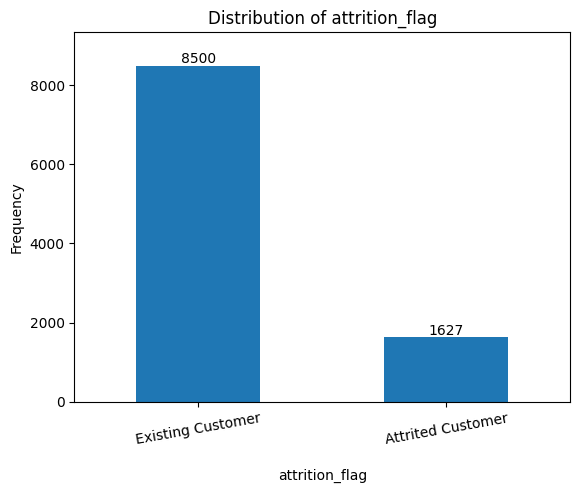

________________________________________________________________________________________________________________________




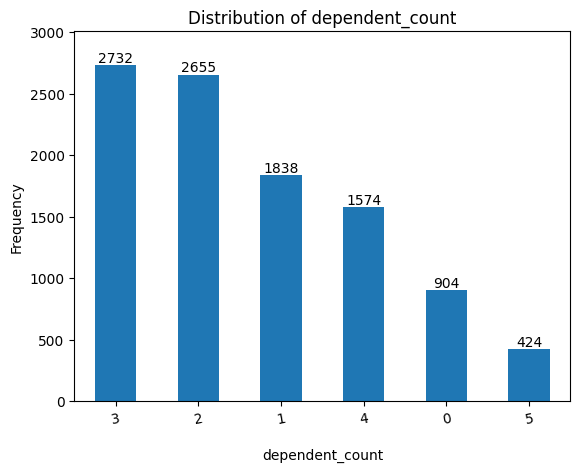

________________________________________________________________________________________________________________________




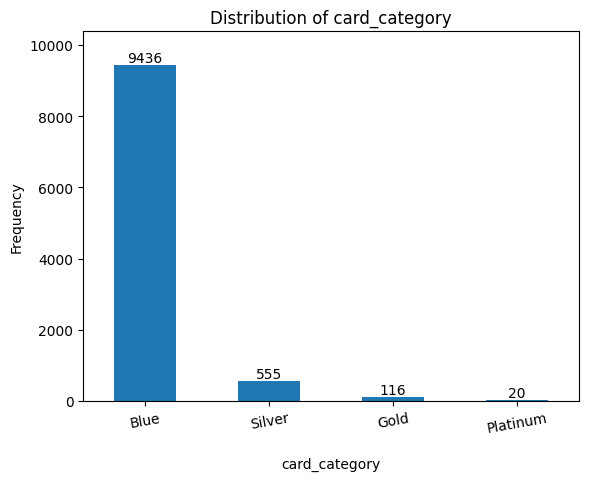

________________________________________________________________________________________________________________________




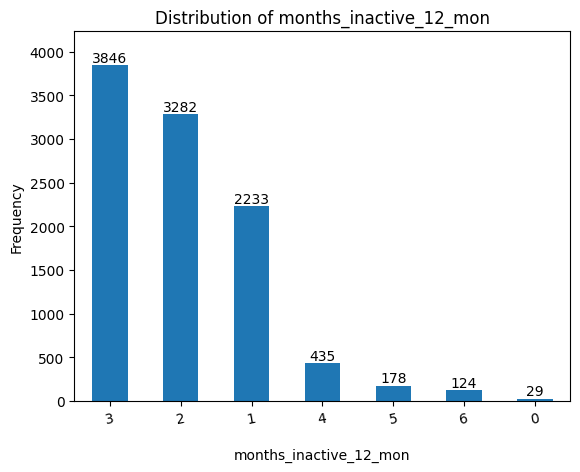

________________________________________________________________________________________________________________________




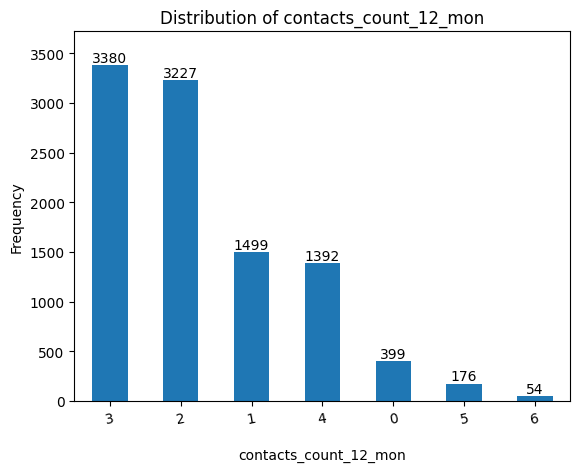

________________________________________________________________________________________________________________________




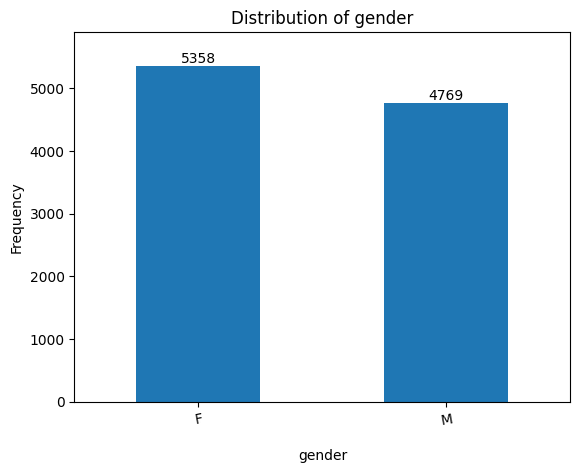

________________________________________________________________________________________________________________________




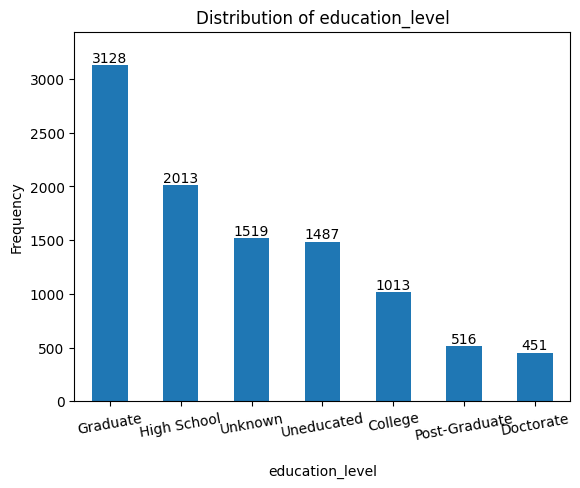

________________________________________________________________________________________________________________________




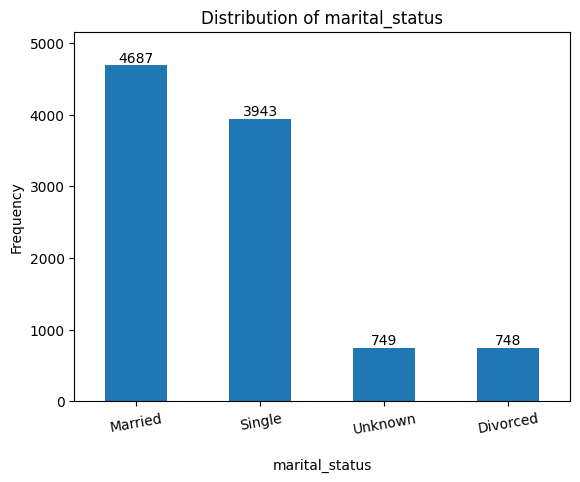

________________________________________________________________________________________________________________________




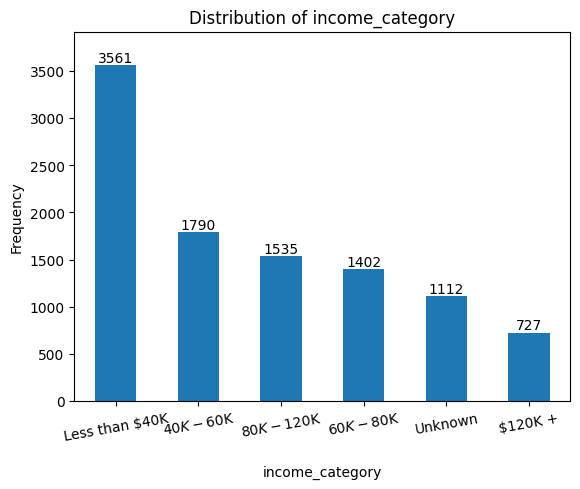

________________________________________________________________________________________________________________________




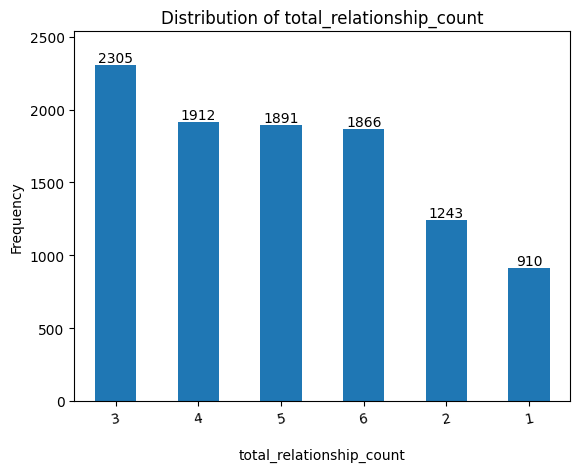

________________________________________________________________________________________________________________________


Using Descriptive Statistics To Show How Values Are Distributed In Numerical Columns That Have Too Many Unique Values



,months_on_book,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,35.928409,8631.953698,7469.139637,0.274894,46.325960,1162.814061,0.759941,4404.086304,0.712222,64.858695
std,7.986416,9088.776650,9090.685324,0.275691,8.016814,814.987335,0.219207,3397.129254,0.238086,23.472570
min,13.000000,1438.300000,3.000000,0.000000,26.000000,0.000000,0.000000,510.000000,0.000000,10.000000
25%,31.000000,2555.000000,1324.500000,0.023000,41.000000,359.000000,0.631000,2155.500000,0.582000,45.000000
50%,36.000000,4549.000000,3474.000000,0.176000,46.000000,1276.000000,0.736000,3899.000000,0.702000,67.000000
75%,40.000000,11067.500000,9859.000000,0.503000,52.000000,1784.000000,0.859000,4741.000000,0.818000,81.000000
max,56.000000,34516.000000,34516.000000,0.999000,73.000000,2517.000000,3.397000,18484.000000,3.714000,139.000000


In [8]:
# Creating an empty list that will be used to store columns that have unique values too many to be plotted
column_list = []

# Using a for loop so I don't have to repeat the process for each step
for column_name in df.columns:
    unique_vals = df[column_name].value_counts().sort_values(ascending=False).index
    unique_count = len(unique_vals)

    # Check to see if the number of unique values are less than 10. If so, plot the distribution 
    if unique_count < 10:
        # Count the frequency of each entity type
        entity_counts = df[column_name].value_counts()

        # Plot the frequency distribution as a bar plot
        ax = entity_counts.plot(kind='bar', title= f"Distribution of {column_name}", xlabel= f"\n{column_name}", ylabel= "Frequency", legend=False)

        ax.bar_label(ax.containers[0], label_type= 'edge')

        ax.margins(y=0.1)
        plt.xticks(rotation=10)
        plt.show();
        
        print("_" * 120)
        print("\n")
    
    # If the column has too many unique values that a distribution plot would not make sense, then add to list
    else:
        column_list.append(column_name)


text = "Using descriptive statistics to show how values are distributed in numerical columns that have too many unique values\n"

print(text.title())

# Use descriptive statistics to show how values are distributed in numerical columns that have too many unique values
df[column_list].describe()
        

From our distribution analysis of each column above,

The attrition_flag column has categorical data and 2 unique values, hence a bar chart is satisfactory to show the distribution of customers who have churned (attrited) to those who are still existing customers. 

Most of the bank's credit card customers have 3 or 2 dependants, while only few have 5 dependants in their care.

The blue credit card category is the most popular with approx. 93% of customers belonging to this card category. In second place is the Silver credit card, and then the Gold credit card. Customers who own a Platinum credit card are very few, accounting for a meager 0.2% of all customers.

In the last 12 months, the majority of customers are inactive for 3 months or less; while only a select few customers have been inactive for longer periods. 

The same trend is also noticed in the number of contacts made by customers, as majority of customers have made contact 3 or 2 times in the last 12 months.

There are more female customers than male customers, with a difference of 589 more female customers than male.

Majority of the credit card customers are graduates accounting for alsmot 31% of all customers, while minority  of the customers have doctorate or post-graduate degrees.

More customers earn less than 40k while less customers earn 120k or higher.

Most customers use 3 of the bank's products. Almost the same number of customers use 4, 5 or 6 of the bank's products. Fewer customers only have 1 product from the bank.

For numerical columns, the table shows the distribution of the variables. 
The shortest recorded month on book for a customer is 13 months while some customers have been around for up to 56 months. 36 months is the median number of months on book for the bank's customers.
There are records of extremely high and extremely low card utilization ratios; however, the median average utilization ratio is 0.18.
The youngest credit card customer is aged 26, while the oldest is aged 73. There are more customers aged 46 as this is the mdeian age.





# Cross-Correlation Analysis
By cross-examining columns against each other, more insights and broader questions can be asked and answered. So let's see how variables are correlated to each other.
 
 

In [10]:
# Checking correlations between all numeric variable in the dataset
df.corr()

,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct
dependent_count,1.000000,-0.103062,-0.010768,-0.040505,0.068065,0.068291,-0.037135,-0.122254,-0.039076,-0.002688,-0.035439,0.025046,0.011087,0.049912
months_on_book,-0.103062,1.000000,0.074164,-0.010774,0.007507,0.006732,-0.007541,0.788912,-0.009203,0.008623,-0.048959,-0.038591,-0.014072,-0.049819
months_inactive_12_mon,-0.010768,0.074164,1.000000,0.029493,-0.020394,-0.016605,-0.007503,0.054361,-0.003675,-0.042210,-0.032247,-0.036982,-0.038989,-0.042787
contacts_count_12_mon,-0.040505,-0.010774,0.029493,1.000000,0.020817,0.025646,-0.055471,-0.018452,0.055203,-0.053913,-0.024445,-0.112774,-0.094997,-0.152213
credit_limit,0.068065,0.007507,-0.020394,0.020817,1.000000,0.995981,-0.482965,0.002476,-0.071386,0.042493,0.012813,0.171730,-0.002020,0.075927
avg_open_to_buy,0.068291,0.006732,-0.016605,0.025646,0.995981,1.000000,-0.538808,0.001151,-0.072601,-0.047167,0.007595,0.165923,-0.010076,0.070885
avg_utilization_ratio,-0.037135,-0.007541,-0.007503,-0.055471,-0.482965,-0.538808,1.000000,0.007114,0.067663,0.624022,0.035235,-0.083034,0.074143,0.002838
customer_age,-0.122254,0.788912,0.054361,-0.018452,0.002476,0.001151,0.007114,1.000000,-0.010931,0.014780,-0.062042,-0.046446,-0.012143,-0.067097
total_relationship_count,-0.039076,-0.009203,-0.003675,0.055203,-0.071386,-0.072601,0.067663,-0.010931,1.000000,0.013726,0.050119,-0.347229,0.040831,-0.241891
total_revolving_bal,-0.002688,0.008623,-0.042210,-0.053913,0.042493,-0.047167,0.624022,0.014780,0.013726,1.000000,0.058174,0.064370,0.089861,0.056060


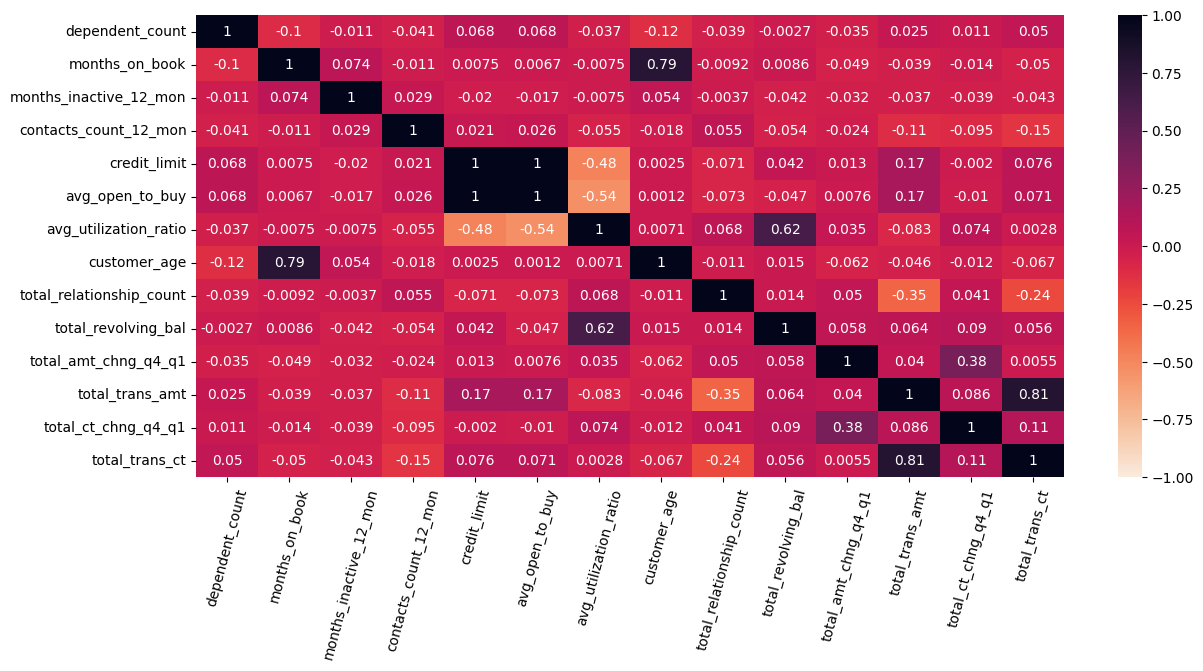

In [11]:
# Let's use correlation heatmaps to display the same information but in a visually appealing way.

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 6))

sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap="rocket_r")

plt.xticks(rotation=75)
plt.show()


The correlation heatmap above helped me to start asking the right questions that can generate useful insights for the bank. Some of them include:
- How long have clients of different ages been customers of the bank's credit card service, and what is the relationship between age and months on book? 
- What is the relationship between credit limit of clients or average open to buy credit, and the avg utilization ratio in the last 12 months? 
- How does transaction amount increase or decrease based on the number of products that clients use? 

To answer these questions, numerical columns can be plotted against each other using scatter plots to better understand the correlation trends between them. For example, making a scatter plot of total transaction count vs total transaction amount, or avg utilization ratio vs total revolving balance. Also numerical columns like months_on_book, months_inactive_12_mon, contacts_count_12_mon and Avg_Utilization_Ratio can be plotted against categorial columns with unique values like attrition_flag, gender, education_level and/or income_category, using preferably a bar chart or other charts like a pie chart or tree map, depending on the number of unique values in the categorical column. 


# Raising Data Questions
After the distribution and cross-correlation analyses performed above, I now have a better understanding of the bank's dataset, and can raise data questions to try and find clues and answer to help in my investigation.
Grouping by the attrition flag or categorical demographic columns would help in plotting bar charts, pie charts, creating text tables and even tree maps using columns that hold numerical data about credit card usage patterns and repayment habits of all clients of the bank, in order to understand the reasons for leaving and recommend ways the bank can mitigate existing customers from churning.

Some possible data questions that can be raised include:

- How do the total relationship count (i.e number of products customers have) differ between age groups, or gender, or income category or any other demographic? A bar chart of total relationship count (numerical datatype) vs demographic categorical column can be used to answer this question.
- On average, how many of the bank's products do customers typically have? Who are the top or bottom customers by number of the bank's products they have? A histogram plot of the total_relationship_count and a text table showing top and bottom customers of the bank by their total product count, can be used to answer such questions.
- Which is the most popular credit card category? What type of credit card holders have churned the most? What is the credit limit according to the different credit card categories? How much credit is currently available for a customer to use based on the type of credit card they have? A histogram of the card_category, bar chart of card_category vs attrition_flag, text table of average credit_limit grouped by card_category, and a text table of avg_open_to_buy grouped by card_category can answer such questions.
- Does the number of dependents per customer affect their credit card needs or usage? Is there a relationship between dependent count and the type of credit card/credit limit a customer has? Plotting a graph of dependent count vs avg utilization ratio or total_trans_ct can answer the first question. A bar chart of dependent count vs credit limit or card category vs dependent count can answer the second question.
- Who are the top (10 or 20) and bottom (10 or 20) clients based on % change in transaction count or % change in transaction amount from Q1 to Q4? Are there any significant differences in % change for churned customers compared to existing customers? Are there any observed patterns when plotting these % change columns grouped by demographic columns? The total_amt_chng_q4_q1 and total_ct_chng_q4_q1 columns which are both numerical columns  can be used to create a text table of top or bottom (10 or 20) clients based on their unique client numbers (clientnum column). Bar charts can also be used to answer these questions by grouping demographic columns like gender, marital status, education or income category.

But for now, I would select the most investigative questions out of the list of so many questions that can reveal the possible reasons why customers are churning and other insights that might have a direct or indirect connection to this problem.

## Question 1: What type of credit card holders have churned the most?

In [44]:
import numpy as np

result1 = df.groupby('card_category')['clientnum'].count().reset_index(name='total_customer_count')
result2 = df.groupby('card_category')['attrition_flag'].apply(lambda x: (x == 'Attrited Customer').sum()).reset_index(name='churned_count')

text_table = result1.merge(result2, on='card_category')

text_table['overall_churn_rate_pct'] = np.round(text_table['churned_count'] / len(df) * 100, 1)
text_table['churn_ratio'] = np.round(text_table['total_customer_count'] /text_table['churned_count'], 1)

text_table.sort_values(by='overall_churn_rate_pct', ascending=False)



,card_category,total_customer_count,churned_count,overall_churn_rate_pct,churn_ratio
0,Blue,9436,1519,15.0,6.2
3,Silver,555,82,0.8,6.8
1,Gold,116,21,0.2,5.5
2,Platinum,20,5,0.0,4.0


### Answer:

The churn rate % shows that the bank's blue credit card holders have churned the most with a 15% churn rate. For Silver, Gold and Platinum credit card customers, the churn rate is less than 1% which is below the generally acceptable churn rate levels of around 5-8% for most banks and credit card companies. From this perspective, it can be seen that the customers with blue credit cards tend to churn the most compared to other credit card categories that the bank offers.

The churn ratio column is being used to add context since the number of customers with blue credit cards are relatively larger than all the other three card categories combined. Now all of a sudden we see that 1 in 4 platinum credit card holders are more likely to churn, 1 in approx 5 Gold credit card customers are more likely to churn, 1 in 6 Blue credit card customers are more likely to churn, and finally 1 in approx 7 Silver credit card customers are more likely to churn. From this perspective, it appears that Platinum credit card customers might be the most unhappy with the bank's credit card services. This is because out of a small number of only 20 total customers with a platinum credit card, 4 of them have churned.

Could this be related to the income category of customers in certain card categories? Or could there be something else happening? Let us investigate further. 


## Question 2: Is there a relationship between credit card category, income category and the usage of credit cards by customers?

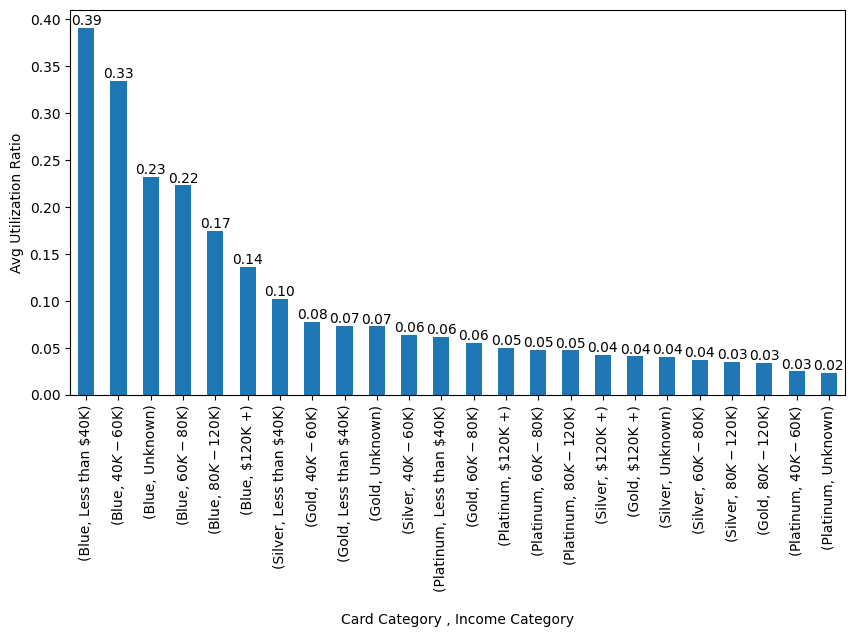

In [45]:
# Grouping by card category & income category to see card utilization trends
view = df.groupby(['card_category', 'income_category'])['avg_utilization_ratio'].mean().sort_values(ascending=False)

# Using a suitable figure/chart size for the plot
plt.figure(figsize = [10, 5])
ax = view.plot(kind='bar', xlabel="\nCard Category , Income Category" , ylabel= "Avg Utilization Ratio", legend=False)

ax.bar_label(ax.containers[0], fmt='%.2f', label_type= 'edge')

plt.show();

### Answer:

The plot above shows that on average, Blue credit card customers who earn less than $40k and those who earn between 40k-60k tend to use their credit cards the most; while Platinum credit card customers who earn between 40k-60k and those whose income category is unknown, tend to use their credit card the least.

On average, Blue credit card customers of all income categories tend to use their cards way more than Silver, Gold and Platinum credit card customers. And average usage trends amongst Silver, Gold and Platinum credit card customers who earn higher than 60k does not differ much, indicating that these customers are not heavily dependent on their credit cards and might also suggest that they are less likely to be interested in trying out other credit products/services the bank offers. 

It is worth investigating further to see how factors such as dependent count affect the credit card needs of customers.

## Question 3: How does income category & number of dependents per customer affect their credit card needs or usage?

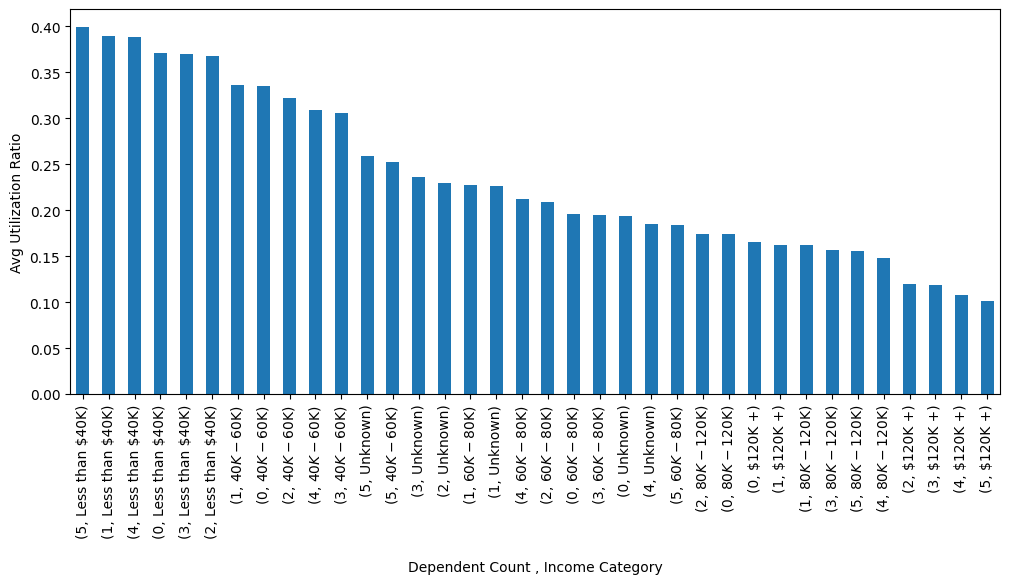

In [46]:
# Grouping by dependent count & income category to see card utilization trends
view = df.groupby(['dependent_count', 'income_category'])['avg_utilization_ratio'].mean().sort_values(ascending=False)

# Using a suitable figure/chart size for the plot
plt.figure(figsize = [12, 5])
ax = view.plot(kind='bar', xlabel="\nDependent Count , Income Category" , ylabel= "Avg Utilization Ratio", legend=False)

#ax.bar_label(ax.containers[0], fmt='%.2f', label_type= 'edge')

plt.show();

There is no clear correlation between credit card utilization and number of dependants, but when income category is grouped with dependent count, some ineteresting insights can be obtained.

We can see that on average, customers who earn less than 40k use their credit cards the most regardless of their number of dependants.
Customers who earn between 40k-60k and those who earn between 60k-80k are not significantly different in their card usage rates regardless of their dependent count.
But as earnings further increased, we observed a trend where credit card utilization decreased as number of dependants increased, especially for customers earning 120k or higher.

In general, Card Utilization decreased as income increased suggesting that customers who earn higher tend to use their credit cards less.  

## Question 4: What age groups utilize their credit cards the most and the least? And What age groups have the most churned customers?

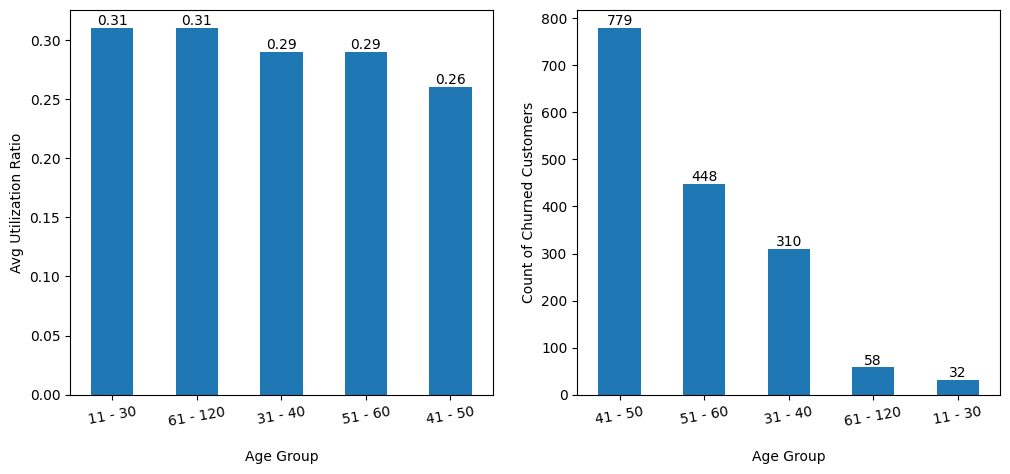

In [47]:
# Creating a new column to group customers according to their age groups
import numpy as np

conditions = [
    (df['customer_age'] > 10) & (df['customer_age'] <= 30),
    (df['customer_age'] > 30) & (df['customer_age'] <= 40),
    (df['customer_age'] > 40) & (df['customer_age'] <= 50),
    (df['customer_age'] > 50) & (df['customer_age'] <= 60),
    (df['customer_age'] > 60) & (df['customer_age'] <= 120)
    ]

values = ['11 - 30', '31 - 40', '41 - 50', '51 - 60', '61 - 120']
    
df['age_group'] = np.select(conditions, values)



first_view = df.groupby(['age_group'])[('avg_utilization_ratio')].apply(lambda x: np.round(x.mean(), 2)).sort_values(ascending=False)

second_view = df.groupby(['age_group'])['attrition_flag'].apply(lambda x: (x == 'Attrited Customer').sum()).sort_values(ascending=False)

# Resize the chart, and have two plots side-by-side
# Set a larger figure size for subplots
plt.figure(figsize = [12, 5]) 

# 1 row, 2 cols, subplot 1
plt.subplot(1, 2, 1)
# Plot a bar chart with the data
ax = first_view.plot(kind='bar', xlabel="\nAge Group" , ylabel= "Avg Utilization Ratio", legend=False)
# Include the bar labels
ax.bar_label(ax.containers[0], label_type= 'edge')
# Rotate the x ticks
plt.xticks(rotation=10)

# 1 row, 2 cols, subplot 2
plt.subplot(1, 2, 2)
# Plot a bar chart with the data
ax = second_view.plot(kind='bar', xlabel="\nAge Group" , ylabel= "Count of Churned Customers", legend=False)
# Include the bar labels
ax.bar_label(ax.containers[0], label_type= 'edge')
# Rotate the x ticks
plt.xticks(rotation=10)

# Now show the figure
plt.show();

Here we see that on average, the difference in credit card utilization amongst age groups is not so much; with customers in the 11-30 age group using their credit cards the most while customers in thee 41-50 age groups have the lowest utilization ratio.
However, the count of churned customers per age group adds context to this analysis. Now we see that the customers aged between 41 and 50 have churned the most, while customers between 11 and 30 churned the least.
From this perspective, a big focus should be made on customers in the 41-50 age group, and more data should be collected to enrich the dataset and provide deeper insights about this group of customers in particular and all age groups in general.

# Data Enrichment

When enriching a customer churn dataset for a bank's credit card service, the following additional variables may be useful to collect:

Internal data points such as customer complaints history, complaints resolution times, customer satisfaction ratings/comments/suggestions, can help perform better customer churn and retention analyses.

External data points like industry trends and economic indicators such as inflation rate, interest rates, unemployment rate, consumer sentiments and changes in GDP. 
This is because high inflation can reduce the purchasing power of consumers and make it more difficult for them to manage credit card debt. Changes in interest rates can affect the affordability of credit card debt and the attractiveness of credit card rewards programs; by benchmarking with the average industry interest rate, the bank can offer more competitive interest rates to retain existing clients and mitigate churn. High unemployment rates can affect consumer confidence and spending habits, which can impact credit card usage. And finally, consumer sentiments as well as changes in GDP greatly impact spending habits and credit card usage.
Thus these economic indicators can provide valuable context for understanding customer behavior and predicting churn, while also identifying opportunities to improve customer retention and maximize profitability.

These external data points are readily available through public/private, free and paid data sources online, some of which are:

- World Bank Open Data: https://data.worldbank.org/
- US Government's Open Data Portal: https://www.data.gov/ 
- AWS Public Datasets: https://aws.amazon.com/public-datasets/
- Google's Dataset Search: https://datasetsearch.research.google.com/
- UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/index.php
- Data World: https://data.world/
- Statista for unemployment rates, economic indicators and customer sentiments data: https://www.statista.com/
- Bloomberg Datasets for economic indicators: https://data.bloomberg.com/
- Alpha Vantage API for Economic Indicators : https://www.alphavantage.co/documentation/
- Bright Data for Customer Sentiments Data: https://brightdata.com/
- US Government Bureau of Labor Statistics for U.S unemployment rates: https://www.bls.gov/
- Statistics Canada for unemployment, economic indicators & customer sentiments: https://www.statcan.gc.ca/
- Kaggle Datasets: https://www.kaggle.com/datasets.


 -------------------------------------------------------------------------------------------------------------------- 

# Tableau Tasks

This Tableau task lets you be creative with the way you build your dashboard and only gives guidance on the types of visualizations you should use.

Create a dashboard that will contain at least 5 out of the 8 requirements defined below:

1. **At least 2 KPIs** as Big Ass Numbers. Choose the metrics on your own that will fit with the rest of your analysis. Examples of metrics:
    - Total number of clients
    - Churn rate %
    - Average transaction amount per customer
    - Average transaction amount before churn
    - etc.
2. **Churn rate %** among different **age groups**. You will need to:
    - Use the Bins function to split client age into age ranges
    - Define Churn rate % as a calculated field
    - Choose the way of visualizing the comparison
3. **A Scatterplot** visualizing certain customer spending behaviors and their connection to the churn if exists. For example, you can compare Total transaction amount and Total transaction count of each client and use color to mark churned and existing customers. 
4. **A Highlight Table** comparing Churn rate % among two demographic dimensions (from *basic_client_info* table), where one is placed on Rows and another on Columns, forming a matrix. 
5. **A Bar Chart** with multiple metrics by Clientnum, where each row represents one Client and has multiple metrics as columns. Add a few filters or parameters to let user drill down into the set of clients they are interested in.
6. **A Pareto Analysis** based on custom defined **customer segment**. 
    - Segment can include values from the demographic information of the client. For example,
        - Gender | Income
        - Gender | Income | Marital status
        - etc.
    - Choose the metric to analyse. For example,
        - Total number of clients (People from which customer segments most often become our clients?)
        - Churn rate absolute (How many churned customers we have in each segment?)
        - Churn rate % (What is the relative churn rate in each customer segment?)
        - etc.
7. **At least 1 parameter** that allows dashboard user to interact with the dashboard. For example,
    - to change the metric used in the chart(s)
    - to change the value of a benchmark
8. At least one **more visualization of your choice** adds value to your analysis.

![Cropped - Customer Churn Dashboard](Cropped%20-%20Customer%20Churn%20Dashboard.png)

[Link to Dollar Bank Customer Churn Tableau Dashboard](https://public.tableau.com/app/profile/nsikan.udoma/viz/DollarBankCustomerChurnDashboard/CustomerChurnDashboard)